<h3> Create the dataset and visualize the data
    


In [1]:
import numpy as np

#so lets create a dataset of 10k data points
num = 10000

np.random.seed(0)
x1 = np.random.rand(num, 1)

np.random.seed(1)
x2 = np.random.rand(num, 1)

#creating the dataset
data = np.hstack((x1, x2))

#we will now create the labels using 1:1 corresponding mapping
labels = np.zeros_like(data[:, 0])
temp = data.copy()
temp[temp>=0.5] = 1
temp[temp<0.5] = 0
temp = temp.astype(np.int32)
for i in range(num):
    labels[i] = temp[i][0] ^ temp[i][1] 

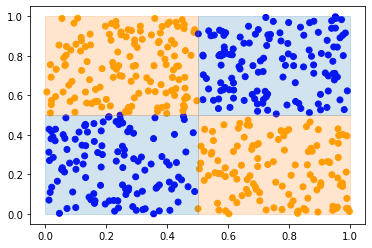

In [2]:
#lets plot
import matplotlib.pyplot as plt

col = np.where(labels[:500]==1,'orange', 'blue')
plt.scatter(data[:500, 0], data[:500, 1], c= col)
plt.fill_between([0, 0.5], 0, 0.5, color='tab:blue', alpha=0.2)
plt.fill_between([0.5, 1], 0, 0.5, color='tab:orange', alpha=0.2)
plt.fill_between([0, 0.5], 0.5, 1, color='tab:orange', alpha=0.2)
plt.fill_between([0.5, 1], 0.5, 1, color='tab:blue', alpha=0.2)

plt.show()

In [3]:
#just to free up some memory
del col, temp, x1, x2

<h3> Creating the algorithm</h3>
<br>
For an MLP to replicate XOR functionality, we need at least 1 hidden layer due to the non linearity!
So I have created this architecture which has input layer + 2 layers(2 neurons and 1 neuron respectively)<br>
XOR(x1,x2) = AND(OR(x1, x2), NAND(x1,x2))

In [4]:
proposal_sig = 2

class XOR_NN():
    # the MLP class
    def __init__(self, sed=None):
        #get seed to check results with the same start point
        np.random.seed(sed)
        self.layer1 = np.array(np.random.randn(2,3)+[[5, 5, -4], [-3, -3, 4]], dtype = np.float64)   #warm starting
        if sed != None: np.random.seed(sed+1)
        self.layer2 = np.array(np.random.randn(1,3)+[3, 3, -4], dtype = np.float64)
        self.weights = [0, 0]
        self.weights[0] = self.layer1
        self.weights[1] = self.layer2
        self.weights = np.asarray(self.weights, dtype = object)

    def sig(self, xS):
        #sigmoid implementation
        for i in range(len(xS)):
            xS[i] = 1/(1+np.exp(-xS[i]))
        return xS
    
    def forward(self, inp: np.array):
        #a forward pass
        self.inp = np.append(inp, 1).reshape(1,3)
        self.hid_rep = np.matmul(self.inp, np.transpose(self.weights[0]))
        self.hid_rep = self.sig(self.hid_rep)
        self.hid_rep = np.append(self.hid_rep, 1)
        self.op = np.matmul(self.hid_rep, np.transpose(self.weights[1]))
        self.op = self.sig(self.op)
        return self.op
    

def gen_temp(x):
    #generate a proposal!
    templayer1 = np.array(np.random.randn(2,3))*proposal_sig + x[0]
    templayer2 = np.array(np.random.randn(1,3))*proposal_sig + x[1]
    temp = [0, 0]
    temp[0] = templayer1
    temp[1]= templayer2
    temp = np.asarray(temp, dtype = object)
    temp_model = XOR_NN()
    temp_model.weights = temp
    return temp_model  #x as the mean and std of proposal distribution as proposal_sig uniform for all weights


def prior(x: XOR_NN):
    #designed prior to check conditions on the weights beinging in accordance to the OR/NAND/AND functions!
    p=1
    wt = x.weights
    if(3*wt[0][0][0] < wt[0][0][2]):
         p+=1
    if(3* wt[0][0][1] < wt[0][0][2]):
        p+=1
    if(wt[0][1][0] > 3*wt[0][1][2]):
        p+=1
    if(wt[0][1][1] > 3*wt[0][1][2]):
        p+=1
    if(3*wt[1][0][0] < wt[1][0][2]):
        p+=1
    if(3*wt[1][0][1] < wt[1][0][2]):
        p+=1
    return p/7


def calc_likelihood(data, labels, model: XOR_NN):
    preds = []
    for i in data:
        z = model.forward(i)
        if z>0.5:
            preds.append(1)
        else:
            preds.append(0)
    preds = np.array(preds)-labels
    preds = preds.astype(np.float64)
    likli = np.count_nonzero(preds==0)/len(preds)
    return likli


def acceptance(a, b):
#     print(b, a)
    if b>a:
        return True
    else:
        accept=np.random.uniform(0.25,1)
        return (accept < (b-a))


def hastings(data, labels, accept, iterations, models: XOR_NN):
    #the hastings sampling algorithm
    accepted = []
    rejected = []   
    for i in range(iterations):
        x = models.weights
        x_new =  gen_temp(x)    
        x_lik = calc_likelihood(data, labels, models)
        x_new_lik = calc_likelihood(data, labels, x_new) 
        if i%20 == 0: 
            print(f'Iteration:{i}: curAcc: {x_lik}, proposedAcc: {x_new_lik}')
        if (accept(x_lik*(prior(models)),x_new_lik*(prior(x_new)))):            
            models = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)            
    return np.array(accepted), np.array(rejected)

In [ ]:
model = XOR_NN(8)

accep, rejecc = hastings(data, labels, acceptance, 2000, model)


Getting the best model from all accepted models

In [ ]:
x= []
for i in accep:
    x.append(calc_likelihood(data, labels, i))
bestMod= accep[np.argmax(x)]

Implementing a random sampler to get baseline acc:


In [11]:
def random_acceptor(b, a):
    if(np.random.uniform(0,1)>=0.5):
        return True
    else:
        return False
    
def random_gen_temp(x, random_sig):
    templayer1 = np.array(np.random.randn(2,3))*random_sig + x[0]
    templayer2 = np.array(np.random.randn(1,3))*random_sig + x[1]
    temp = [0, 0]
    temp[0] = templayer1
    temp[1]= templayer2
    temp = np.asarray(temp, dtype = object)
    temp_model = XOR_NN()
    temp_model.weights = temp
    return temp_model

def random_sampler(data, labels, iterations, models:XOR_NN):
    accepted = []
    rejected = []
    for i in range(iterations):
        x = models.weights
        x_new = random_gen_temp(x, abs(np.random.randn()*0.5))
        x_lik = calc_likelihood(data, labels, models)
        x_new_lik = calc_likelihood(data, labels, x_new)
        if i%20 == 0: 
            print(f'Iteration:{i}: curAcc: {x_lik}, proposedAcc: {x_new_lik}')
        if(random_acceptor(x_lik, x_new_lik)):
            models = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)  
    return accepted, rejected

In [21]:
model = XOR_NN(8)

randaccep, randrejecc = random_sampler(data, labels, 1000, model)

Iteration:0: curAcc: 0.4958, proposedAcc: 0.4958
Iteration:20: curAcc: 0.4958, proposedAcc: 0.4958
Iteration:40: curAcc: 0.5319, proposedAcc: 0.508
Iteration:60: curAcc: 0.4958, proposedAcc: 0.4958
Iteration:80: curAcc: 0.4958, proposedAcc: 0.6396
Iteration:100: curAcc: 0.5042, proposedAcc: 0.5042
Iteration:120: curAcc: 0.5042, proposedAcc: 0.5042
Iteration:140: curAcc: 0.5042, proposedAcc: 0.5042
Iteration:160: curAcc: 0.5042, proposedAcc: 0.5042
Iteration:180: curAcc: 0.5042, proposedAcc: 0.5042
Iteration:200: curAcc: 0.5042, proposedAcc: 0.5042
Iteration:220: curAcc: 0.5042, proposedAcc: 0.5042
Iteration:240: curAcc: 0.5042, proposedAcc: 0.5042
Iteration:260: curAcc: 0.5042, proposedAcc: 0.5042
Iteration:280: curAcc: 0.5042, proposedAcc: 0.5042
Iteration:300: curAcc: 0.5042, proposedAcc: 0.5042
Iteration:320: curAcc: 0.5042, proposedAcc: 0.5042
Iteration:340: curAcc: 0.5042, proposedAcc: 0.5042
Iteration:360: curAcc: 0.5042, proposedAcc: 0.5042
Iteration:380: curAcc: 0.5042, propose

Getting the best model from all accepted models

In [24]:
x= []
for i in randaccep:
    x.append(calc_likelihood(data, labels, i))
bestModRandom= randaccep[np.argmax(x)]

<h3> Creating the test set and testsing our model!</h3>


In [ ]:
#so lets create a testset of 1k data points
testnum = 1000

np.random.seed(0)
x1 = np.random.rand(testnum, 1)

np.random.seed(1)
x2 = np.random.rand(testnum, 1)

#creating the dataset
testdata = np.hstack((x1, x2))

#we will now create the labels using 1:1 corresponding mapping
testlabels = np.zeros_like(testdata[:, 0])
temp = testdata.copy()
temp[temp>=0.5] = 1
temp[temp<0.5] = 0
temp = temp.astype(np.int32)
for i in range(testnum):
    testlabels[i] = temp[i][0] ^ temp[i][1] 

In [ ]:
preds = []
for i in testdata:
    z = bestMod.forward(i)
    if z>=0.5:
        preds.append(1)
    else:
        preds.append(0)
preds = np.array(preds)-testlabels
preds = preds.astype(np.float64)
likli = np.count_nonzero(preds==0)/len(preds)
print(f'Best Acc:{likli}')

for j in testdata:
    datapred = []
    for i in accep:
        z = i.forward(j)
        if z>0.5:
            datapred.append(1)
        else:
            datapred.append(0)
    z = np.mean(datapred)
    if z>=0.5:
        predAcc.append(1)
    else:
        predAcc.append(0)

predAcc = np.array(predAcc)-testlabels
predAcc = predAcc.astype(np.float64)
likli = np.count_nonzero(predAcc==0)/len(predAcc)
print(f'Random Ensemble:{likli}')

In [25]:
# randaccep = accep
predsRand = []
for i in testdata:
    z = bestModRandom.forward(i)
    if z>=0.5:
        predsRand.append(1)
    else:
        predsRand.append(0)
predsRand = np.array(predsRand)-testlabels
predsRand = predsRand.astype(np.float64)
likli = np.count_nonzero(predsRand==0)/len(predsRand)
print(f'Best Acc:{likli}')

predAccRand = []
for j in testdata:
    datapred = []
    for i in randaccep:
        z = i.forward(j)
        if z>0.5:
            datapred.append(1)
        else:
            datapred.append(0)
    z = np.mean(datapred)
    if z>=0.5:
        predAccRand.append(1)
    else:
        predAccRand.append(0)

predAccRand = np.array(predAccRand)-testlabels
predAccRand = predAccRand.astype(np.float64)
likli = np.count_nonzero(predAccRand==0)/len(predAccRand)
print(f'Random Ensemble:{likli}')

Best Acc:0.55
Random Ensemble:0.517


<h3> Save Model!</h3>


In [33]:
#to save model we just need to save the np array of weights!

np.save("./bestMod.npy",bestMod.weights)

In [34]:
#to load the model we just need to load the weights!
XOR_Model = XOR_NN()
XOR_Model.weights = np.load("./bestMod.npy", allow_pickle=True)

In [35]:
preds = []
for i in testdata:
    z = XOR_Model.forward(i)
    if z>0.5:
        preds.append(1)
    else:
        preds.append(0)
preds = np.array(preds)-testlabels
preds = preds.astype(np.float64)
likli = np.count_nonzero(preds==0)/len(preds)
# likli = ((np.sum(preds*preds))**0.5)/num
print(likli)

0.844
